<a href="https://colab.research.google.com/github/juampyvillar/TP2SOA/blob/master/Cuaderno_2_Grupo9_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introducción** 

El siguiente ejemplo consiste en generar un gran volumen de datos, en este caso usaremos una lista de listas que va incrementando su cantidad de elementos. Con cada lista utilizaremos el algoritmo de ordenamiento merge-Sort para ordenar cada una de ellas. El ordenamiento merge-Sort tiene una complejidad O(N*log n), por lo cual el mismo es uno de los mas eficientes.  Cada vez que ordenemos una lista se tomará el tiempo de ejecucion que conlleva la misma para luego realizar un grafico. Gracias a esto, podremos comparar los resultados que conlleva ordenar una lista utilizando el algoritmo de ordenamiento merge sort en listas pequeñas y listas mas grandes comparandolo con el algoritmo de ordenamiento merge sort modificando levemente su codigo para correr en paralelo la ejecucion.

En resumen, compararemos el ordenamiento merge sort secuencial con el ordenamiento merge sort en paralelo utilizando una lista de listas. Se comparará utilizando graficos de matplot. pandas y numpy para el manejo de los datos.






**2.  Armado del ambiente**

In [ ]:
#@title # 3.1 Parametros de ejecución
#@markdown ---
#@markdown ### Especifique la cantidad de listas a generar :
from random import randint
import time
import pandas as pd
import random
import time
import timeit as tt


def generar_listas(N):
    
    listaDeListas=[]
    for valor in range(1,N+1):
        lista=[]
        for i in range(valor):
            lista.append(randint(1,1000))
        listaDeListas.append(lista)    
    return listaDeListas

cantDeListas=1500 #@param {type:"integer"}
listaTotales=generar_listas(cantDeListas)
print("LISTAS GENERADAS:")
print(listaTotales)
print("Continue...")


**3. Desarrollo**

Ordenamiento Merge-Sort - Secuencial

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def merge_sort(lista):
    """Ordena lista mediante el método merge sort.
       Pre: lista debe contener elementos comparables.
       Devuelve: una nueva lista ordenada."""
    if len(lista) < 2:
        lista_nueva = lista
    else:
        medio = len(lista) // 2
        izq= merge_sort(lista[:medio])
        der= merge_sort(lista[medio:])
        lista_nueva= merge(izq, der)
    
    return lista_nueva

    
def merge(lista1, lista2):
    """Intercala los elementos de lista1 y lista2 de forma ordenada.
       Pre: lista1 y lista2 deben estar ordenadas.
       Devuelve: una lista con los elementos de lista1 y lista2."""
    i, j = 0, 0
    resultado = []

    while(i < len(lista1) and j < len(lista2)):
        if (lista1[i] < lista2[j]):
            resultado.append(lista1[i])
            i += 1
        else:
            resultado.append(lista2[j])
            j += 1

    # Agregar lo que falta de una lista
    resultado += lista1[i:]
    resultado += lista2[j:]

    return resultado

def aux(lis):
   lista_ordenada=merge_sort(lis.copy())
   #print("Lista Ordenada -> ",lista_ordenada)

def experimento_timeit_merge_secuencial(listas, num):
    """
    Realiza un experimento usando timeit para evaluar el método
    de selección para ordenamiento de listas
    con las listas pasadas como entrada
    y devuelve los tiempos de ejecución para cada lista
    en un vector.
    El parámetro 'listas' debe ser una lista de listas.
    El parámetro 'num' indica la cantidad de repeticiones a ejecutar el método para cada lista.
    """
    tiempos_seleccion = []
    
    global lista
    
    for lista in listas:
        #print("Lista -> ",lista)
        # evalúo el método de selección
        # en una copia nueva para cada iteración
        tiempo_seleccion = tt.timeit('aux(lista.copy())', number = num, globals = globals())
        
        # guardo el resultado
        tiempos_seleccion.append(tiempo_seleccion)
        
    # paso los tiempos a arrays
    tiempos_seleccion = np.array(tiempos_seleccion)
    
    return tiempos_seleccion 


tiempos_merge_secuencial = experimento_timeit_merge_secuencial(listaTotales.copy(), 100)

plt.figure(figsize=(8, 6), dpi=80)
plt.title("Tiempo en ordenamiento Secuencial")
plt.xlim(0,cantDeListas)
plt.ylim(0,0.8)
plt.xlabel("Tamaño de lista")
plt.ylabel("tiempo de ejecucion")
plt.plot(tiempos_merge_secuencial,color="yellow",label="Ordenamiento Merge Secuencial")
plt.legend(loc='upper left')
plt.show()



Ordenamiento Merge Sort - Paralelo

Dividiremos la lista en sublistas y le indicaremos a cada proceso  su sublista, luego haremos un merge con las dos sublistas ordenadas.

In [ ]:
from multiprocessing import cpu_count
import multiprocessing
from multiprocessing import Manager, Pool
from contextlib import contextmanager
import os
import math


@contextmanager
def process_pool(size):
    pool = Pool(size)
    yield pool
    pool.close()
    pool.join()

def merge_multiple(results, array_part_left, array_part_right):
  results.append(merge_paralelo(array_part_left, array_part_right))
  print("Lista ordenada->",results)

def merge_sort_multiple(results, lis):
  results.append(merge_sort_paralelo(lis))

def merge_sort_paralelo(lista):
    """Ordena lista mediante el método merge sort.
       Pre: lista debe contener elementos comparables.
       Devuelve: una nueva lista ordenada."""
    if len(lista) < 2:
        lista_nueva = lista
    else:
        medio = len(lista) // 2
        izq= merge_sort_paralelo(lista[:medio])
        der= merge_sort_paralelo(lista[medio:])
        lista_nueva= merge_paralelo(izq, der)
    return lista_nueva

    
def merge_paralelo(lista1, lista2):
    """Intercala los elementos de lista1 y lista2 de forma ordenada.
       Pre: lista1 y lista2 deben estar ordenadas.
       Devuelve: una lista con los elementos de lista1 y lista2."""
    i, j = 0, 0
    resultado = []

    while(i < len(lista1) and j < len(lista2)):
        if (lista1[i] < lista2[j]):
            resultado.append(lista1[i])
            i += 1
        else:
            resultado.append(lista2[j])
            j += 1

    # Agregar lo que falta de una lista
    resultado += lista1[i:]
    resultado += lista2[j:]

    return resultado

def auxiliar(liss):
    print("Lista->",liss)
    processes = multiprocessing.cpu_count()
    step = int(len(liss) / processes)
    manager = Manager()
    results = manager.list()
    with process_pool(size=processes) as pool:
        for n in range(processes):
           if n < processes - 1:
              chunk = liss[n * step:(n + 1) * step]
              print("Proceso",n,"va a ordenar",chunk)
           else:
              chunk = liss[n * step:]
              print("Proceso",n,"va a ordenar",chunk)
           pool.apply_async(merge_sort_multiple, (results, chunk))
    while len(results) > 1:
        with process_pool(size=processes) as pool:
            pool.apply_async(merge_multiple,(results, results.pop(0), results.pop(0))
            )

def experimento_timeit_merge_paralelo(listas, num):
    """
    Realiza un experimento usando timeit para evaluar el método
    de selección para ordenamiento de listas
    con las listas pasadas como entrada
    y devuelve los tiempos de ejecución para cada lista
    en un vector.
    El parámetro 'listas' debe ser una lista de listas.
    El parámetro 'num' indica la cantidad de repeticiones a ejecutar el método para cada lista.
    """
    tiempos_seleccion = []
    processes = multiprocessing.cpu_count()
    print("Cores",processes)
    global lista
    for lista in listas:
          tiempo_seleccion = tt.timeit('auxiliar(lista.copy())', number = num, globals = globals())
          # guardo el resultado
          tiempos_seleccion.append(tiempo_seleccion)

    # paso los tiempos a arrays
    tiempos_seleccion = np.array(tiempos_seleccion)
    
    return tiempos_seleccion 




tiempos_merge_paralelo = experimento_timeit_merge_paralelo(listaTotales.copy(), 1)
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Tiempo en ordenamiento Paralelo")
plt.xlim(0,cantDeListas)
plt.ylim(0,1)
plt.xlabel("Tamaño de lista")
plt.ylabel("tiempo de ejecucion")
plt.plot(tiempos_merge_paralelo,color="blue",label="Ordenamiento Merge Paralelo")
plt.legend(loc='upper left')
plt.show()


**4. Metricas**

En el siguiente fragmento de codigo, realizaremos un grafico comparando ambos resultados para mejor observacion de los informacion obtenida.

In [ ]:
tiempos_merge_secuencial = experimento_timeit_merge_secuencial(listaTotales.copy(), 100)
tiempos_merge_paralelo = experimento_timeit_merge_paralelo(listaTotales.copy(), 1)

plt.figure(figsize=(8, 6), dpi=80)
plt.title("Tiempo en ordenamiento Secuencial")
plt.xlim(0,cantDeListas)
plt.ylim(0,2)
plt.xlabel("Tamaño de lista")
plt.ylabel("tiempo de ejecucion")
plt.plot(tiempos_merge_secuencial,color="yellow",label="Ordenamiento Merge Secuencial")
plt.plot(tiempos_merge_paralelo,color="blue",label="Ordenamiento Merge Paralelo")
plt.legend(loc='upper left')
plt.show()

Generamos una lista de 1400 listas dentro de la misma con elementos random.
Ejecutamos el ordenamiento merge sort secuencial, dando como resultado lo siguiente:
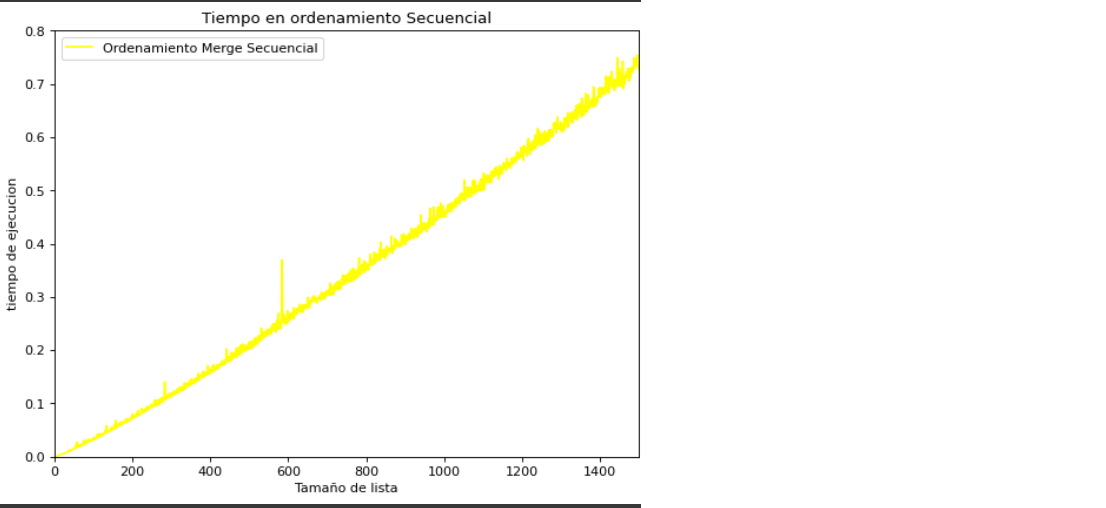


Luego ejecutamos el ordenamiento Merge sort de forma paralela, dandonos como resultado lo siguiente:  

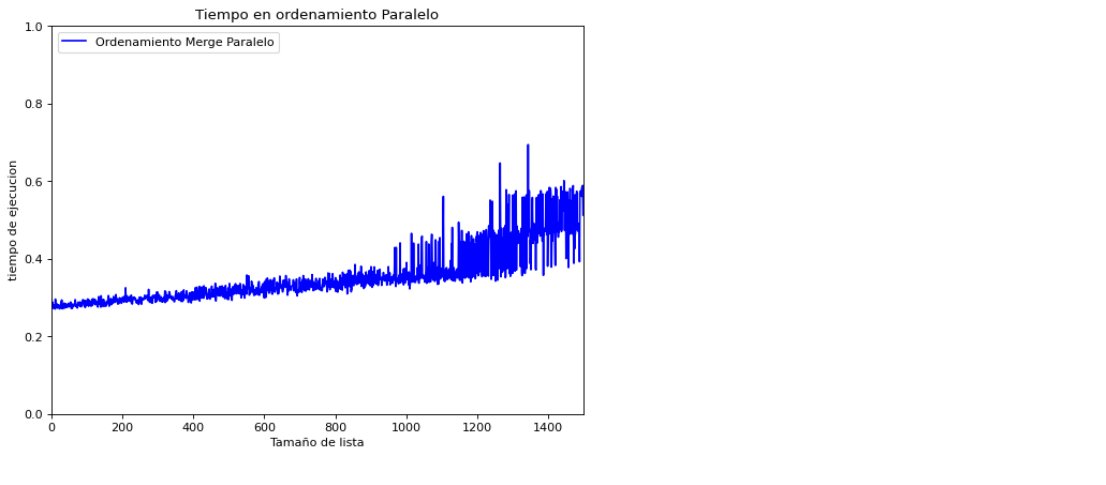

Al juntar los graficos obtenemos lo siguiente:   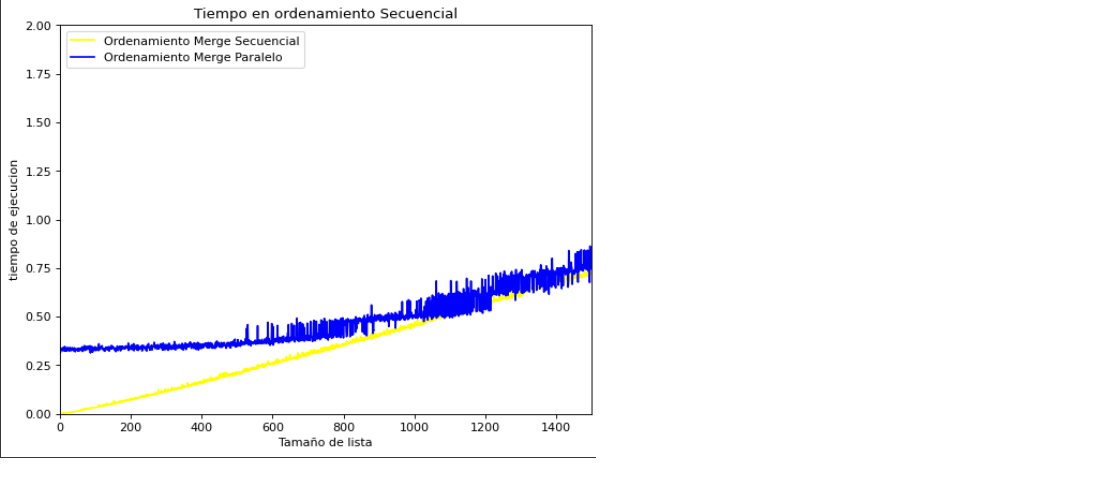


**5. Conclusiones**

Como pudimos observar en los resultados obtenidos, el rendimiento de el merge sort secuencial tiene mejores tiempos de ejecucion al tratarse de listas de poca cantidad de elementos. Esto se debe a que en listas mas pequeñas, el rendimiento en paralelo no es tan eficiente, al tratarse de que en colab solo se tiene dos cores, y el merge del final para ordenar cada sublista de cada proceso conlleva un tiempo extra. Esto se podria reducir quiza con un core mas.
Con listas de mucha cantidad de elementos, podemos observar en los graficos obtenidos que utilizando el merge sort de forma secuencial el tiempo se eleva de forma lineal, hasta que alcanza el tiempo de ejecucion del merge sort de forma paralela y hasta lo supera. 

Como conclusion podemos afirmar que solo es viable utilizar el merge sort paralelo en listas de mucha cantidad de elementos.

Aclaracion: Creemos que se puede mejorar el codigo del merge sort paralelo, especialmente cuando dividimos en izquierda y derecha de la lista ya que la parte izquierda tiene que terminar hasta que pueda empezar la derecha, pero realizamos el trabajo en paralelo en otro sector del codigo.

**6. Bibliografía**

[1]	La librería Pandas, https://aprendeconalf.es/docencia/python/manual/pandas/

[2]	Wes McKinney, pandas: a Foundational Python Library for Data Analysis and Statistics https://www.dlr.de/sc/portaldata/15/resources/dokumente/pyhpc2011/submissions/pyhpc2011_submission_9.pdf

[3].	Wes McKinney, Python for data Analysis, http://www.aaronyeo.org/books/Data_Science/Python/Wes%20McKinney%20-%20Python%20for%20Data%20Analysis.%20Data%20Wrangling%20with%20Pandas,%20NumPy,%20and%20IPython-O%E2%80%99Reilly%20(2017).pdf

[4] MergeSort Example using Python Multiprocessing https://devopslog.wordpress.com/2012/04/15/mergesort-example-using-python-multiprocessing/

[5] Curso Python https://github.com/python-unsam/Programacion_en_Python_UNSAM/blob/master/Notas/Slack.md
